# Extreme Rainfall in New York

On September 1st 2021, hurricane Ida hit NYC causing extreme rainfall resulting in deadly flash floods.
Nearby EWR airport witnessed an hourly rainfalll of 3.24 inches between 20:00-21:00; a record in its 74-year history. The previous records was from the 2006-07-21 thunderstorm resulting in 2.35 inches. One might wonder, is such an extereme event statistically to happen once in a while (say every 100 years), or is this an indication of a changing climate.

*link: https://www.nytimes.com/live/2021/09/02/nyregion/nyc-storm*

## What is a hunderd year event?
Whenever we observe an extreme event the question is, is this an infrequent event but statistically probably. Or is this an "outlier", a sign that the system has changed and hence the past is no relevant for the future.

So what we want to quantity is, for a given *return period* (eg 100 years), what extreme value do we expect to observe. We quickly sketch three possible approaches:

### 1. Ideal Scenario (lots of data)
Say we have 10,000 years of data and want to know what a once in 100 years event is. We can quantify this by looking at the 99-th percentile. Pretty straightforward, but in practive we rarely encounter time series with sufficient history. Also we are assuming that the we can describe the time series with the same statistical model over its entire history.

### 2. Naive approach
Say we have only 100 years of data. Our estimate for a 100 year event is the most highest(extreme) event observed in the past. 

a. This is reasonable but also a huge estimation error.
b. We throw all data away (execept one data point)

### 3. Extreme Value Theory (fitting the tails)
Instead one can fit the data to a statistical distribition. We can use extreme value theory, which tells use that under lose conditions the "tail" of a distribution converages a (In a similar spirit of how )

In [1]:
#imports
import sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
sys.path.append('..')
import scipy as sp

from extremevalue.gpd import GPDMLE, GEVMLE_ts

### Hourly Rainfall Data EWR Airport (1948-Present)

https://mesonet.agron.iastate.edu/request/asos/hourlyprecip.phtml?network=NJ_ASOS

In [2]:
#load data
df_hourly = pd.read_csv('../ewr_hourly_prcp.csv',parse_dates=['valid'],usecols=['valid','precip_in'])
df_hourly = df_hourly.rename(columns={'valid':'datetime'})
df_hourly['date'] = df_hourly['datetime'].dt.date
df_hourly['time'] = df_hourly['datetime'].dt.time

In [3]:
def ts_interpolate(ts):
    dt_start = ts.index.min()
    dt_end = ts.index.max()
    df_range = pd.date_range(dt_start,dt_end)
    return ts.reindex(df_range,fill_value=0.0)

In [4]:
#max hourly precipitation per day
ts_hourly_max = df_hourly.groupby(['date'])['precip_in'].max()
ts_hourly_max = ts_interpolate(ts_hourly_max)

#total precipitation per day
ts_daily = df_hourly.groupby(['date'])['precip_in'].sum()
ts_daily = ts_interpolate(ts_daily)

### Generalized Pareto Distribution



The probability distribution for the right tail of a distribution is

$$P(X-\mu > y|X>u)$$

If we send the threshold u to infinity, extreme value theory tells us that the probability distribution converages to 

$$P(X-\mu > y|X>u) \rightarrow G(z)$$

With $G(z)$ the Generalized Pareto Distribution
$$G(z; \xi) = 1 - (1+\xi z)^{-1/\xi}$$ 
and $z = (x-\mu)/\sigma$

and for $\xi=0$ $G(z) = 1 - \exp (-z)$

The parameter $\xi$ describes "fattness" of the tails, the bigger $\xi$ the "fatter" the tails.

For $\xi<0$ the support of x is finite. Ie there is a finite maximum

### Fixing the threshold $\mu$
The threshold parameter $\mu$ defines which values "constitutes" the tail. 
For this purpose we set it at the 99th-percentile, ie we use the 1% most extreme observations, to fit the tail.
Fixing the thershold typically requires a bit of analysis (which we will address in a different notebook). One the one hand you want to set the thershold as high as possible, so that GDP approximation becomes more and more correct. On the other hand, we need a sufficiently large sample size for robust estimation

In [5]:
u_daily = ts_daily.quantile(0.9925)
u_daily = ts_daily.sort_values().iloc[-200]

u_daily, (ts_daily>=u_daily).sum()

(1.75, 200)

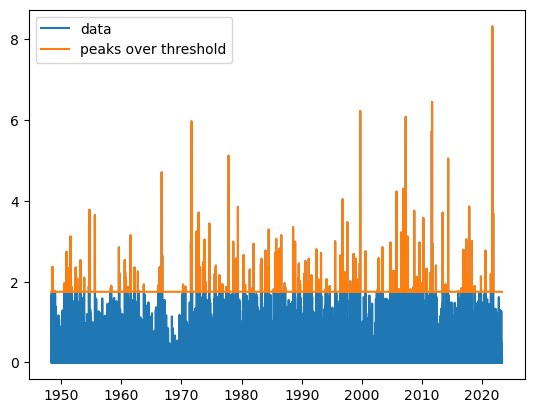

In [6]:
plt.plot(ts_daily, label='data')
plt.plot(ts_daily.index,np.maximum(ts_daily.values,u_daily), label='peaks over threshold')
plt.legend()

#### Fit the GPD with MLE

In [7]:
gpd_daily = GPDMLE(u_daily)
gpd_daily.fit(ts_daily.values)
gpd_daily.get_params()

{'xi': 0.17300297942092852, 'sigma': 0.6745066366265695}

Fitted GDP distribution vs emperical distribution

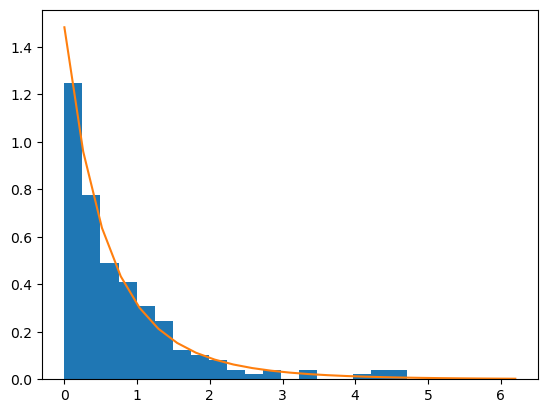

In [8]:
gpd_daily.dist_plot(n=25)

### Return Levels

We have now all to ingredients to answer the question what a once in a hunderd years event is.

Given a *return period* $m$ (eg once every 100 years) the *return level* $x_m$ satisfies
$$P(X>x_m) = \frac{1}{m}$$
In other words, we expect to observe a value of at least $x_m$ with a probality inversely proportional to the *return period* $m$. We can rewrite the probablity for the return level as

$$P(X>x_m) = P(X>x_m | X>\mu) P(x>\mu) $$
Where we used the GDP for $P(X>x_m | X>u)$ and defined $P(X>u) = \zeta_{\mu} $. We can model this by estimation the fraction of the data which exceeds the threshold $\mu$. 

*[This is also a hint of how we want to chose $\mu$, we want to make it large enough so that the paretor distr approximation applies, but sufficiently small to have enough samples for a robust estimate of $\zeta_\mu$]*

Putting everything together

$$ \zeta_{\mu} \left( 1 + \xi \frac{x_m-\mu}{\sigma}  \right)^{-1/\xi} = \frac{1}{m} $$

The return level as fuction of the return period

$$ x_m = \mu + \frac{\sigma}{\xi} \left( (m \zeta_\mu)^\xi - 1\right) $$




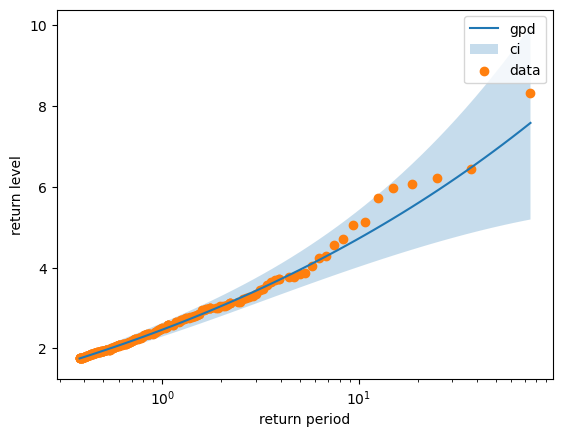

In [9]:
gpd_daily.return_level_plot(include_ci=True,period=365.25,include_data=True)

In [10]:
{rp: gpd_daily.return_level(rp, period=365.25) for rp in [25,50,75,100,125]}

{25: 5.90046214827184,
 50: 6.9259621341544975,
 75: 7.585385357653782,
 100: 8.08211362854899,
 125: 8.484796180752582}

Comparing with the most extreme observations

In [11]:
def extremes(ts,gpd,n=5):
    ts_extremes = ts.sort_values().tail(n).to_frame('percip_in')
    ts_extremes['return period'] = ts_extremes['percip_in'].apply(lambda x : gpd.return_period(x,period=365.25))
    return ts_extremes

In [12]:
ts_daily_extremes = extremes(ts_daily,gpd_daily)
ts_daily_extremes

,percip_in,return period
1971-08-27,5.9700,26.274451
2007-04-15,6.0800,28.399925
1999-09-16,6.2300,31.525718
2011-08-28,6.4500,36.620769
2021-09-01,8.3204,114.234441


The observation of 8.32 on 2021-09-01, is about once in a hunder year event

### GPD fit for hourly data

Now lets repeat the same excerise, but for hourly data instead


In [13]:
# u_hourly = ts_hourly_max.quantile(0.9925)
u_hourly = ts_hourly_max.sort_values().iloc[-200]

gpd_hourly = GPDMLE(u_hourly)
gpd_hourly.fit(ts_hourly_max.values)
gpd_hourly.get_params()


/Users/mosselveen/dev/extremeweather/.conda/lib/python3.10/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in log
  return f_raw(*args, **kwargs)


{'xi': 0.11505030561733373, 'sigma': 0.2603865288662804}

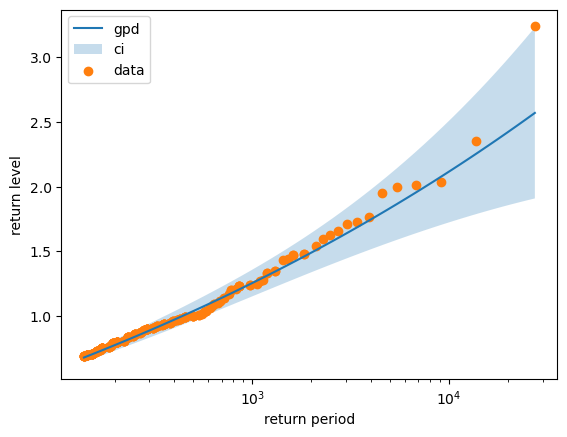

In [14]:
gpd_hourly.return_level_plot(include_ci=True, include_data=True)

In [15]:
{rp: gpd_hourly.return_level(rp, period=365.25) for rp in [100,150,200,300,400]}

{100: 2.710687989282658,
 150: 2.915740523508958,
 200: 3.0671390660780578,
 300: 3.289213587092169,
 400: 3.4531801479061004}

In [16]:
ts_hourly_extremes = extremes(ts_hourly_max,gpd_hourly)
ts_hourly_extremes

,percip_in,return period
1995-07-17,2.00,20.749348
2020-07-24,2.01,21.258100
1974-08-17,2.04,22.851233
2006-07-21,2.35,46.644786
2021-09-01,3.24,274.663088


# Is this a sign of a changing climate?

Not necessarily, however it warrants further research. Staying on te statistical track (ie not leveraging external insights from climatology), we define a time-varying model. For instance we can model that shape parameter $\xi$ to slowly vary over time. Obviously this is a model with more parameters, so we need something like AIC to determine whether this model

### Confidence intervals

One of the advantages of using MLE is that it also provides us a framework for estimation uncertainty.


* MLE
* Asymptotic normality for MLE estimates
* Cov matrix for GPD parameters
* Delta Method
* Confidence interval for return periods

Caveats
* Verify normal approximation is valid
* We expect the interval to be asymmetric, and positive
* Verify with a Bayesian approach

# What is next?

1. How to calibrate the threshold parameter u
2. How to compute confidence intervals for the return levels
3. How to get more robust esitmate using data from nearby station
4. Time varying models (use Temperature as exogenus variable)

In [17]:
def gpd_excess_mean(ts,u):
    gpd = GPDMLE(u)
    gpd.fit(ts.values)
    return gpd.excess_mean()

In [18]:
def excess_mean_emperical(ts,u):

    ts_excess = (ts[ts>u]-u)

    mean = ts_excess.mean()

    se = ts_excess.std()/np.sqrt(len(ts_excess))

    z = 1.96

    return mean, (mean-z*se,mean+z*se)

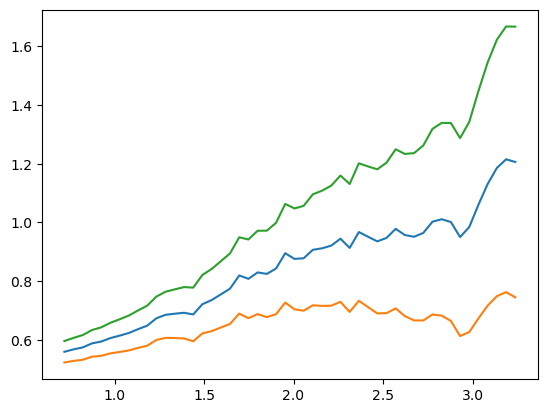

In [19]:
u0 = ts_daily.quantile(0.95)
u1 = ts_daily.quantile(0.999)

u_vals = np.linspace(u0,u1,50)

mean_vals = [excess_mean_emperical(ts_daily,u)[0] for u in u_vals]
mean_vals_L = [excess_mean_emperical(ts_daily,u)[1][0] for u in u_vals]
mean_vals_U = [excess_mean_emperical(ts_daily,u)[1][1] for u in u_vals]
fit_mean_vals = [gpd_excess_mean(ts_daily,u) for u in u_vals]

plt.plot(u_vals,mean_vals)

plt.plot(u_vals,mean_vals_L)
plt.plot(u_vals,mean_vals_U)




In [20]:
# u0 = ts_hourly_max.quantile(0.95)
# u1 = ts_hourly_max.quantile(0.999)

# u_vals = np.linspace(u0,u1,50)

# mean_vals = [excess_mean_emperical(ts_hourly_max,u) for u in u_vals]
# fit_mean_vals = [gpd_excess_mean(ts_hourly_max,u) for u in u_vals]

# plt.plot(u_vals,mean_vals)
# plt.plot(u_vals,fit_mean_vals)

In [21]:
u0 = ts_daily.quantile(0.95)
u1 = ts_daily.quantile(0.999)

u_vals = np.linspace(u0,u1,100)

xi_vals = []

for u in u_vals:

    gpd = GPDMLE(u)
    gpd.fit(ts_daily.values)
    params = gpd.get_params(include_ci=True)

    xi_vals.append({
        'u' : u,
        'xi' : params[0]['xi'],
        'xi_L' : params[1]['xi'][0],
        'xi_U' : params[1]['xi'][1],
         
    })


    

<AxesSubplot: xlabel='u'>

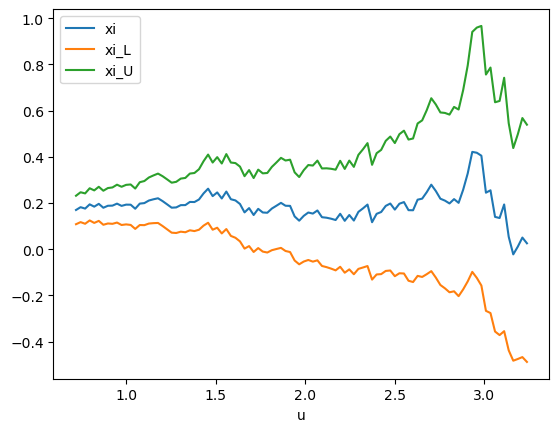

In [22]:
pd.DataFrame(xi_vals).set_index('u').plot()

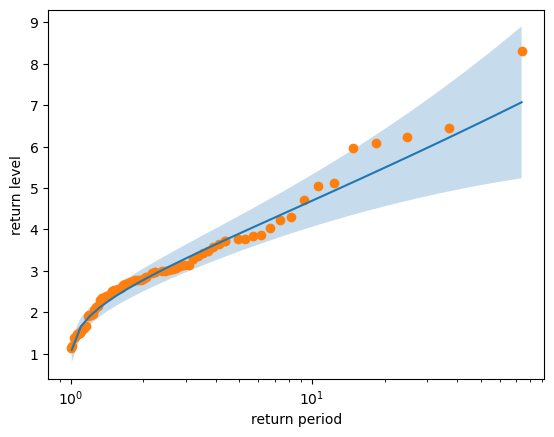

In [39]:
GEV_daily = GEVMLE_ts()
GEV_daily.fit(ts_daily)
GEV_daily.return_level_plot(include_ci=True,include_data=True)

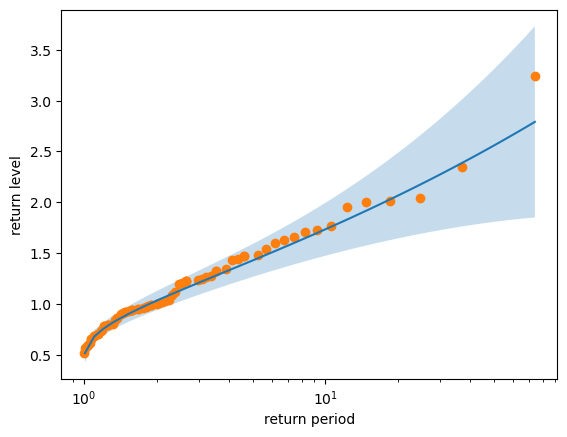

In [24]:
GEV_hourly = GEVMLE_ts()
GEV_hourly.fit(ts_hourly_max)
GEV_hourly.return_level_plot(include_ci=True,include_data=True)

In [25]:
{rp: gpd_hourly.return_level(rp, period=365.25) for rp in [100,150,200,300,400]}

{100: 2.710687989282658,
 150: 2.915740523508958,
 200: 3.0671390660780578,
 300: 3.289213587092169,
 400: 3.4531801479061004}

In [26]:
{rp: GEV_hourly.return_level(rp) for rp in [100,150,200,300,400]}

{100: 2.9798846320432943,
 150: 3.249478882663719,
 200: 3.451877718735883,
 300: 3.753874700122869,
 400: 3.980715718887674}

In [27]:
{rp: gpd_daily.return_level(rp, period=365.25) for rp in [50,100,150,200,300]}

{50: 6.9259621341544975,
 100: 8.08211362854899,
 150: 8.825549177824918,
 200: 9.38556199168097,
 300: 10.223713267267337}

In [28]:
{rp: GEV_daily.return_level(rp) for rp in [50,100,150,200,300]}

{50: 6.584437021222865,
 100: 7.452007612570589,
 150: 7.97752870536275,
 200: 8.358970145053306,
 300: 8.909159966039443}

In [29]:
ts_daily.max()

8.320400000000001

In [43]:
gevp = GEV_daily.get_params()
gevp


{'mu': 2.435069897925917,
 'sigma': 0.9267507208365224,
 'xi': 0.06895958282812467}

In [40]:
def gev_returnlevel(rp, mu, sigma, xi):
    p = 1.0 / rp
    return mu - (sigma / xi) * (1 - np.power(-np.log(1.0 - p), -xi))

In [51]:
gev_returnlevel(100, gevp['mu'], gevp['sigma'], gevp['xi'])

7.452007612570589

In [52]:
gev_returnperiod(7.45200, gevp['mu'], gevp['sigma'], gevp['xi'])

99.9994048668163

In [47]:
def gev_returnperiod(x, mu, sigma, xi):
    p = 1.0 - np.exp(-np.power((x-mu)*(xi/sigma)+1.0,-1.0/xi))
    return 1.0/p


In [31]:
from scipy.stats import genextreme

In [32]:
x_vals = np.linspace(1,8,50)

gev1 = genextreme.pdf(x_vals, GEV_daily_params['xi'], loc = GEV_daily_params['mu'], scale=GEV_daily_params['sigma'])



In [33]:
genextreme.fit(GEV_daily.x_max)

(-0.06895958282812467, 2.435069897925917, 0.9267507208365224)

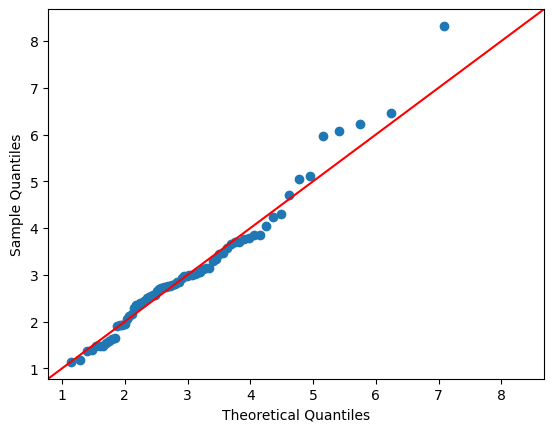

In [34]:
GEV_daily.qq_plot()

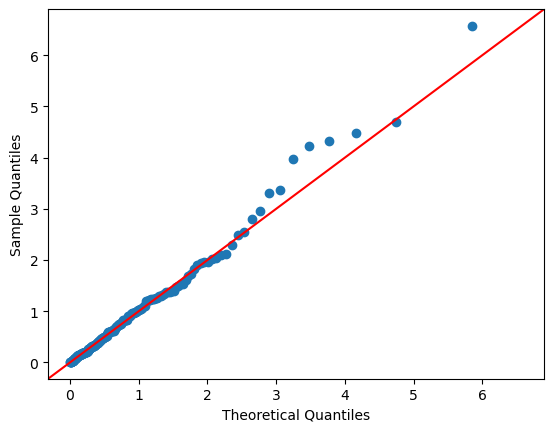

In [35]:
gpd_daily.qq_plot()

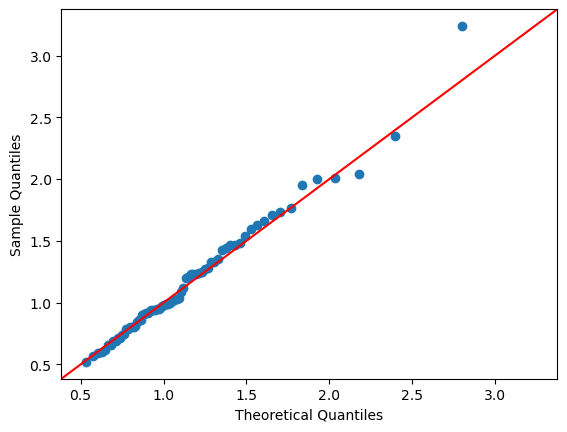

In [36]:
GEV_hourly.qq_plot()

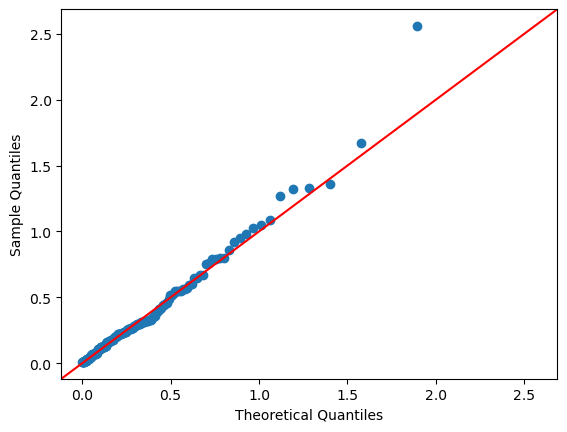

In [37]:
gpd_hourly.qq_plot()

In [53]:
GEV_daily.return_period(8.28)

188.52058237632667

In [54]:
GEV_hourly.return_period(3.24)

147.942627908209